[View in Colaboratory](https://colab.research.google.com/github/RenatoBMLR/Machine_Learning_Python/blob/master/Dog-Breed-Identification/dog_breed_identification.ipynb)

In [28]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install kaggle

In [29]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c dog-breed-identification -p data/ && cd data && ls && unzip train.zip && unzip test.zip && unzip labels.csv.zip
    
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
import numpy as np
import torchvision.transforms as transforms
import torch

In [31]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 2


In [0]:
datadir = 'data/'

In [0]:
import pandas as pd

NUM_CLASSES = 120

labels = pd.read_csv(os.path.join(datadir, 'labels.csv'))


selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

In [34]:
labels_pivot.head()

breed,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001513dfcb2ffafc82cccf4d8bbaba97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001cdf01b096e06d78e9e5112d419397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00214f311d5d2247d5dfe4fe24b2303d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0021f9ceb3235effd7fcde7f7538ed62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
}

In [0]:
from torch.utils.data import Dataset
import random
from PIL import Image


class DogBreedDataset(Dataset):
    
    def __init__(self, path, labels, transforms=None):
    
        self.path = path
        self.labels = labels
        self.transform = transforms        
    
    def __getitem__(self, idx):
      
      
      
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = os.path.join(self.path, img_name)
      
        img = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        
        if self.transform is not None:
            img = self.transform(img)
          
        return img, labels

    def __len__(self):
        return len(self.labels)


In [0]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset

In [0]:
dsets = {
    'train': DogBreedDataset(path=os.path.join(datadir, 'train/'), labels=labels_pivot, transforms=data_transforms['train'])
}

In [0]:
from torch.utils.data import DataLoader


def create_dataLoader(dsets, batch_size,  pin_memory=False, use_shuffle=False):
    dset_loaders = {}
   
    shuffle = False
    for key in dsets.keys():
        if use_shuffle:
            if key != 'test':
                shuffle = True
            else:
                shuffle = False
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle = shuffle)
            
    return dset_loaders

In [0]:
dset_loaders = create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= True)

In [0]:
import numpy as np

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))  # Channel Last
    img = std * inp + mean
    return img

In [0]:
#!pip install --no-cache-dir -I pillow

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def plot_classes(dset_loaders, path2save = './figures/data.png'):
    inputs, cls = next(iter(dset_loaders))
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(cls[j]))
        plt.axis('off')

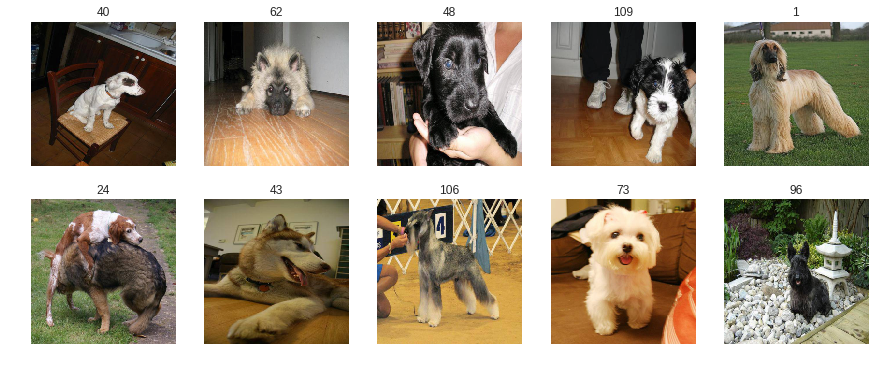

In [44]:
plot_classes(dset_loaders['train'])

In [0]:
import torchvision


# http://pytorch.org/docs/0.2.0/_modules/torchvision/models/densenet.html

# https://discuss.pytorch.org/t/densenet-transfer-learning/7776

nb_out = len(pd.read_csv('data/labels.csv')['breed'].unique())

class MyDenseNetConv(torch.nn.Module):
    def __init__(self, fixed_extractor = True):
        super(MyDenseNetConv,self).__init__()
        original_model = torchvision.models.densenet161(pretrained=True)
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1])
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        return x
        
class MyDenseNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=2208, out_features=512)
        self.dens2 = torch.nn.Linear(in_features=512, out_features=128)
        self.dens3 = torch.nn.Linear(in_features=128, out_features=nb_out)
        
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
        return x


class MyDenseNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyDenseNetConv()
        self.mrnd = MyDenseNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x 

In [0]:
model_name = "DenseNet"    
model = MyDenseNet()

In [47]:
use_gpu = True
use_DataParalel = True

if use_gpu:
    if use_DataParalel:
        print("Using all GPU's ")
       
        model.mrnc = torch.nn.DataParallel(model.mrnc) #device_ids=[1,3]
        convnet = model.mrnc.cuda()
        model.mrnd = torch.nn.DataParallel(model.mrnd) #device_ids=[1,3]
        model.mrnd = model.mrnd.cuda()
        
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
        convnet = model.mrnc 

else:
    print("Using CPU's")
    convnet = model.mrnc

Using all GPU's 


In [0]:
import time
from torch.autograd import Variable
import torch.nn.functional as F


def predict(dset_loaders, model,use_gpu=False):
    
    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)
    start_time = time.time()

    for i, (inputs, labels) in enumerate(dset_loaders):
                   
        if use_gpu:
          inputs = inputs.cuda()
          labels = labels.cuda()

        inputs = Variable(inputs)
        labels = Variable(labels)

        predictions.append(model(inputs).data)
        labels_lst.append(labels)
        
        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    print('Execution time {0:.2f} s'.format(round(time.time()- start_time), 2))
    if len(predictions) > 0:
        return {'pred': torch.cat(predictions, 0), 'true': torch.cat(labels_lst, 0) }

In [76]:
from torch.utils.data import  TensorDataset

#extract features from images

convOutput_train = {}
conv_dset = {}

for k in dset_loaders.keys():
  convOutput_train[k] = predict(dset_loaders['train'], convnet,use_gpu=use_gpu)
  
  train_data = convOutput_train[k]['pred']
  our_labels = convOutput_train[k]['true'].cpu().data

  if use_gpu:
      conv_dset[k] = TensorDataset(train_data.cuda(), our_labels.cuda())
  else:
      conv_dset[k] = TensorDataset(train_data, our_labels)

predict: 319/319 ok
Execution time 363.00 s


In [0]:
dset_loaders_convnet = create_dataLoader(conv_dset, batch_size, pin_memory=False, use_shuffle= True)

In [0]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, ( inputs, labels) in enumerate(loader):     
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [0]:
import copy


def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')

            if use_gpu:
              
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
                
            
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.data[0])
        loss_test.append( evaluate_model(test_loader, model,loss_fn, use_gpu) )
        
        print('\nEpoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        #Early stopping
        
        
        if(best_test_acc > loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    return loss_train, loss_test, model

In [0]:
import torch.nn as nn
import torch.optim as optim


num_epochs  = 50

loss_fn = nn.CrossEntropyLoss()
optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3,weight_decay=0)
patience = 5

In [0]:
params  =  {'model'  :  model.mrnd, 
               'train_loader':dset_loaders_convnet['train'],
               'test_loader':dset_loaders_convnet['train'],
               'num_epochs': num_epochs,
               'loss_fn': loss_fn,
              'optimizer': optimizer, 
               'patience': patience 
             }

In [194]:
loss_train, loss_test, model   = train(**params)

predict: 319/319
Epoch: 0  Loss Train: 0.18920938670635223  Lost Test: 0.5644524662191965
predict: 319/319
Epoch: 1  Loss Train: 1.0298264026641846  Lost Test: 0.5116643363779242
predict: 319/319
Epoch: 2  Loss Train: 0.6078786849975586  Lost Test: 0.47657747193003147
predict: 319/319
Epoch: 3  Loss Train: 0.3516285717487335  Lost Test: 0.418752135668055
predict: 319/319
Epoch: 4  Loss Train: 0.2132209986448288  Lost Test: 0.3650897484868298
predict: 319/319
Epoch: 5  Loss Train: 0.5817404389381409  Lost Test: 0.4338292930754001
predict: 319/319
Epoch: 6  Loss Train: 0.13040399551391602  Lost Test: 0.309576987402753
predict: 319/319
Epoch: 7  Loss Train: 0.8459981083869934  Lost Test: 0.26826714366954696
predict: 319/319
Epoch: 8  Loss Train: 0.031373362988233566  Lost Test: 0.24794052270325748
predict: 319/319
Epoch: 9  Loss Train: 0.44249773025512695  Lost Test: 0.2634577970239436
predict: 319/319
Epoch: 10  Loss Train: 0.48763588070869446  Lost Test: 0.23998070689251055
predict: 319

predict: 319/319
Epoch: 14  Loss Train: 0.7510749101638794  Lost Test: 0.19962052842105818
predict: 319/319
Epoch: 15  Loss Train: 0.6977922320365906  Lost Test: 0.21350199381199003
predict: 319/319
Epoch: 16  Loss Train: 0.2691030502319336  Lost Test: 0.23538225067072902
predict: 319/319
Epoch: 17  Loss Train: 0.2734375  Lost Test: 0.18631479858791566
predict: 319/319
Epoch: 18  Loss Train: 0.23980747163295746  Lost Test: 0.17333531071399821
predict: 319/319
Epoch: 19  Loss Train: 0.039976801723241806  Lost Test: 0.14900021625209753
predict: 319/319
Epoch: 20  Loss Train: 0.2184722125530243  Lost Test: 0.15709082646219522
predict: 319/319
Epoch: 21  Loss Train: 0.16900880634784698  Lost Test: 0.1772651957307116
predict: 319/319
Epoch: 22  Loss Train: 0.31633323431015015  Lost Test: 0.1721575495591358
predict: 319/319
Epoch: 23  Loss Train: 0.6372151374816895  Lost Test: 0.21631028281297057
predict: 319/319
Epoch: 24  Loss Train: 0.40375450253486633  Lost Test: 0.17364487626522687
pred